## Simple Portfolio Optimization


#### In this notebook we are going to:
- build a dataset of returns 
- build a hypothetical portfolio of 10 stocks (any 10)
- start with equal wieghting and caluculate the porfolio returns and varaiance over the past 5 years
- optimize the weighting by adjusting the wieght accoring the the marginal increase/decrease in variance of the portfolio
- we must make rules that ensure a fully invested position 
- we must also consider the retunrs of the portfolio


#### Now that we have minimized the variance, we need to maximize the returns (optimize the sharp ratio)
- this will be a little more difficult
- 

In [1]:
# import libraries 
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import itertools
from pandas_datareader import data as pdr
import datetime as dt
from numpy import nan
from time import sleep
import concurrent.futures
from functools import reduce
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy 
import time
import random

In [2]:
# lets chose 10 stocks for this analysis
# for ease of build, lets use older companies in cananda or the US 


ticker_list = ['ENB', 'RIO', 'GLD', 'DOO', 'F', 'CS', 'TGT', 'MSFT', 'ISRG', 'EMR']

market_proxy = 'SPY'


# lets also set the date range for the backtest window 

startdate = '2014-01-01'
enddate = str(dt.date.today())


# Calculate the number of years (this will ensure robustness of the model)
# Convert the date string to a datetime object
date = datetime.strptime(startdate, "%Y-%m-%d")
# Get the current date
current_date = datetime.now()
# Calculate the difference between the current date and the input date
difference = current_date - date
# Calculate the number of years
years = round(difference.days / 365.25)
years

9

### Lets import the historical quotes

In [3]:
def get_merged_df(market_proxy, ticker_list, years=5):
    
    period = str(years) + 'y'  # make the variable for the period argument in df.history()
    
    proxy_data = yf.Ticker(market_proxy) # first we ge the data on hte market proxy (spy in this case)
    main_df = proxy_data.history(period=period)[['Close']].rename(columns={'Close':'market_proxy'}).reset_index()
    
    df_dict = {} # this will hold the dfs
    
    for ticker in ticker_list:  # collect the historical quotes in the df_dict
        ticker_data = yf.Ticker(ticker)
        ticker_hist = ticker_data.history(period=period)[['Close']].rename(columns={'Close':ticker}).reset_index()
        df_dict[ticker] = ticker_hist
    
    # merge the dataframes into one df
    for key in df_dict.keys():
        main_df = pd.merge(main_df, df_dict[key], how='left', on='Date')
    return main_df, df_dict

In [4]:
main_df, df_dict = get_merged_df(market_proxy, ticker_list, years)
main_df.head()

,Date,market_proxy,ENB,RIO,GLD,DOO,F,CS,TGT,MSFT,ISRG,EMR
0,2014-02-24,156.675629,27.648195,30.389145,128.990005,49.279999,9.832119,23.472122,43.671387,32.178017,48.726665,49.414501
1,2014-02-25,156.616348,27.551523,29.406345,129.210007,49.080002,9.812684,23.375988,43.959213,32.049950,48.318890,49.591202
2,2014-02-26,156.624771,27.306612,29.240820,128.110001,48.650101,9.883931,22.821352,47.055264,31.990194,48.705555,50.113621
3,2014-02-27,157.446716,27.203491,29.835672,128.199997,48.950199,9.968134,22.961857,47.187500,32.323162,49.349998,50.128979
4,2014-02-28,157.844940,27.255054,29.639118,127.620003,48.950001,9.968134,23.198505,48.649975,32.707352,49.425556,50.136665


In [5]:
# inspect the data 
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2267 entries, 0 to 2266
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2267 non-null   datetime64[ns]
 1   market_proxy  2267 non-null   float64       
 2   ENB           2267 non-null   float64       
 3   RIO           2267 non-null   float64       
 4   GLD           2267 non-null   float64       
 5   DOO           2265 non-null   float64       
 6   F             2267 non-null   float64       
 7   CS            2267 non-null   float64       
 8   TGT           2267 non-null   float64       
 9   MSFT          2267 non-null   float64       
 10  ISRG          2267 non-null   float64       
 11  EMR           2267 non-null   float64       
dtypes: datetime64[ns](1), float64(11)
memory usage: 230.2 KB


## Now we can costruct the poirfolio

- Assign a weight to a dictionairy of assets 

In [6]:
# first we will start with equal weights

weight_dict = {}

for ticker in ticker_list:
    weight_dict[ticker] = 1/len(ticker_list)
    
weight_dict

{'ENB': 0.1,
 'RIO': 0.1,
 'GLD': 0.1,
 'DOO': 0.1,
 'F': 0.1,
 'CS': 0.1,
 'TGT': 0.1,
 'MSFT': 0.1,
 'ISRG': 0.1,
 'EMR': 0.1}

In [52]:
# assign the asset variance to a dictionairy
var_dict = {}

for col in main_df.iloc[:, 2:].pct_change().describe():
    var = (main_df.iloc[:, 2:].pct_change().describe()[col][2])**2 # note: we will need to change this back to std later on for some operations
    var_dict[col] = var
    
var_dict

{'ENB': 0.0003057297843589709,
 'RIO': 0.00044522925066671536,
 'GLD': 7.972609269576044e-05,
 'DOO': 0.00011771924565644209,
 'F': 0.00048308236457719517,
 'CS': 0.000549776067558172,
 'TGT': 0.00036799910084631246,
 'MSFT': 0.0002988911330906319,
 'ISRG': 0.00040747331687351673,
 'EMR': 0.00030390006867148713}

In [8]:
# make a dataframe containing all the pairwise correlations 
corr_df = main_df.iloc[:, 2:].pct_change().corr()
corr_df

,ENB,RIO,GLD,DOO,F,CS,TGT,MSFT,ISRG,EMR
ENB,1.000000,0.484916,0.088492,0.612328,0.405015,0.423158,0.230468,0.395940,0.352864,0.546856
RIO,0.484916,1.000000,0.169426,0.651288,0.409400,0.458979,0.229923,0.370189,0.315060,0.526653
GLD,0.088492,0.169426,1.000000,0.118973,-0.003056,-0.007448,-0.002781,0.009149,0.049209,-0.023372
DOO,0.612328,0.651288,0.118973,1.000000,0.559953,0.656883,0.354284,0.589531,0.498586,0.658771
F,0.405015,0.409400,-0.003056,0.559953,1.000000,0.505855,0.297182,0.382406,0.386846,0.558889
CS,0.423158,0.458979,-0.007448,0.656883,0.505855,1.000000,0.290140,0.410301,0.364333,0.538681
TGT,0.230468,0.229923,-0.002781,0.354284,0.297182,0.290140,1.000000,0.354238,0.281042,0.324187
MSFT,0.395940,0.370189,0.009149,0.589531,0.382406,0.410301,0.354238,1.000000,0.571660,0.476879
ISRG,0.352864,0.315060,0.049209,0.498586,0.386846,0.364333,0.281042,0.571660,1.000000,0.453641
EMR,0.546856,0.526653,-0.023372,0.658771,0.558889,0.538681,0.324187,0.476879,0.453641,1.000000


### next we can find the portfolio variation
### for simplicity, we will igngore returns for now 

#### lets make a dictionairy for the variance of each 
- keep in mind that the final formula will have n^2 terms, where n = number of stocks in the portfolio 
- from this, we can see that our 10 stock portfolio has a formula with 100 terms 
- we will do this by calculating the diagonals, and then double 1 of the covariance terms
- note there is an error in this picture. the pairwise terms should use std not variance with correlations
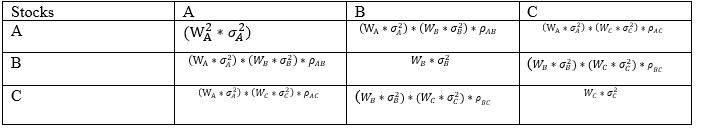

#### now we need to make a function that calculated the variance of the portfolio with the current specified wheights 

In [9]:
# now we can calculate the ramaining pairwise covariance terms 
# note that we will use the correlation instead of the covariance 
# my hope is that we can speed up the optimization by reducing the number calculations


def get_unique_pairs(ticker_list):
    ''' this function will return a set containing only usique combinations of the tickers in our portfolio
    '''
    temp_list = []

    for ticker_i in ticker_list:  # make a list of pair strings
        for ticker_k in ticker_list:
            if ticker_i == ticker_k:
                pass
            else:
                temp_list.append([ticker_i, ticker_k])


    # this function will count the unique pairs of. this number should be 45
    unique_pairs = set()            # this allows us co make half the calcualtions but still get the same answer 
    for i in range(len(temp_list)):
        for j in range(i+1, len(temp_list)):
            for x in temp_list[i]:
                for y in temp_list[j]:
                    if x != y:
                        unique_pairs.add(tuple(sorted((x, y))))
    
    return unique_pairs

unique_pairs = get_unique_pairs(ticker_list)
unique_pairs

{('CS', 'DOO'),
 ('CS', 'EMR'),
 ('CS', 'ENB'),
 ('CS', 'F'),
 ('CS', 'GLD'),
 ('CS', 'ISRG'),
 ('CS', 'MSFT'),
 ('CS', 'RIO'),
 ('CS', 'TGT'),
 ('DOO', 'EMR'),
 ('DOO', 'ENB'),
 ('DOO', 'F'),
 ('DOO', 'GLD'),
 ('DOO', 'ISRG'),
 ('DOO', 'MSFT'),
 ('DOO', 'RIO'),
 ('DOO', 'TGT'),
 ('EMR', 'ENB'),
 ('EMR', 'F'),
 ('EMR', 'GLD'),
 ('EMR', 'ISRG'),
 ('EMR', 'MSFT'),
 ('EMR', 'RIO'),
 ('EMR', 'TGT'),
 ('ENB', 'F'),
 ('ENB', 'GLD'),
 ('ENB', 'ISRG'),
 ('ENB', 'MSFT'),
 ('ENB', 'RIO'),
 ('ENB', 'TGT'),
 ('F', 'GLD'),
 ('F', 'ISRG'),
 ('F', 'MSFT'),
 ('F', 'RIO'),
 ('F', 'TGT'),
 ('GLD', 'ISRG'),
 ('GLD', 'MSFT'),
 ('GLD', 'RIO'),
 ('GLD', 'TGT'),
 ('ISRG', 'MSFT'),
 ('ISRG', 'RIO'),
 ('ISRG', 'TGT'),
 ('MSFT', 'RIO'),
 ('MSFT', 'TGT'),
 ('RIO', 'TGT')}

In [10]:
#first we will calculate the diagonal terms and return the sum


def diagonal_terms(ticker_list, weight_dict, var_dict):
    ''' this function will return the sum of all diagonal terms for the portfolio variance formula (see table)
    '''
    # we will keep this for later use
    #diagonal_dict = {}
    
    diagonal_sum = 0


    for ticker in ticker_list:
        
        # get the asset weight
        weight = weight_dict.get(ticker)
        
        # get the asset variance
        variance = var_dict.get(ticker)
        # store each term dictionairied to its ticker
        term = ((weight**2) * variance)
        
        # we will keep this for later use
        #diagonal_dict[ticker] = term
        
        # store the total sum of all diagonal terms
        diagonal_sum += term

    return diagonal_sum

In [11]:
diagonal_total = diagonal_terms(ticker_list, weight_dict, var_dict)
diagonal_total

3.359526424995206e-05

In [12]:
   
    
def pairwise_terms(unique_pairs, weight_dict, var_dict, corr_df):
    ''' this funciton returns double the sum of all unique pairwise terms
    '''
    
    # this dict will hold teh individual pairwive term values, which we will later need to optimize the portfolio variance 
    #pairwise_terms_dict = {}

    # this will hold the total sum of two times the pairwise term value
    pairwise_total = 0

    for pair in unique_pairs:

        # get the weights for each asset 
        weight_0 = weight_dict.get(pair[0]) # first ticker in the pair
        weight_1 = weight_dict.get(pair[1]) # second ticker in the pair

        # get the variance for each asset
        var_0 = var_dict.get(pair[0])
        var_1 = var_dict.get(pair[1])

        # ge the correlation for each asset pair 
        corr = corr_df.loc[pair[0], pair[1]]

        # create the formula and derive the pairwise term 
        # note that we are not doubling the term in this part. we will do that on line 33
        term = weight_0*weight_1*np.sqrt(var_0)*np.sqrt(var_1)*corr

        # store the term in a dictionair for later use 
        #key_value = pair[0] + ' '+ pair[1]
        #pairwise_terms_dict[key_value] = term

        # here we will double to pairwise term and store the total in an object 
        pairwise_total += 2*term
    
    return pairwise_total

In [13]:
pairwise_total = pairwise_terms(unique_pairs, weight_dict, var_dict, corr_df)
pairwise_total

0.00010917332983783595

### we have just gone through the calculations for one portfolio
 
 
## whats next?

- we need to make a list of lists containing the different combinations of portfolio weights 
- for this we will need some rules 
    - no positional can be less  than 2%
    - no position can be greater than 25% 
    - we must be fully invested at all times (sum of weights must = 1)
- we are trying to minimize teh variance before we can try maximizing the returns 

In [15]:
# this function will make a list of lists containing random weights between 2% & 25%

def generate_weight_list(num_lists, num_weights):
    weight_lists = []
    for i in range(num_lists):
        weights = []
        for j in range(num_weights):
            # Generate a random weight value between 2% and 25%
            weight = random.uniform(0.02, 0.25)
            # Check if the weight is less than 2%
            if weight < 0.02:
                # If so, set it to 2%
                weight = 0.02
            # Check if the weight is greater than 25%
            elif weight > 0.25:
                # If so, set it to 25%
                weight = 0.25
            weights.append(weight)
        # Normalize the weights so that their sum equals 1
        total_weight = sum(weights)
        normalized_weights = [w/total_weight for w in weights]
        weight_lists.append(normalized_weights)
    return weight_lists


list_of_lists = generate_weight_list(10, 10) #we will start with only 10 for teh first try

In [16]:
# now lets adjust the weight_dict to contain the random weights with each interation 


  
for lst in list_of_lists:
    new_dict = {key: value for key, value in zip(weight_dict.keys(), lst)}


In [17]:
columns = list(weight_dict.keys())
columns.append('porfolio_std')
columns.append('porfolio_return')
columns

['ENB',
 'RIO',
 'GLD',
 'DOO',
 'F',
 'CS',
 'TGT',
 'MSFT',
 'ISRG',
 'EMR',
 'porfolio_std',
 'porfolio_return']

# Lets compile all the functions into one plot the findings 

In [40]:
portfolio_daily_std_list = []

columns = list(weight_dict.keys())
columns.append('porfolio_std')
columns.append('porfolio_return')


weights_risk_return_df = pd.DataFrame(columns=columns)



# step 1:
    # find all the unique pairs
pairwise_total = pairwise_terms(unique_pairs, new_dict, var_dict, corr_df)

# step 2:
    # make a list of lists containing random weights
list_of_lists = generate_weight_list(10000, 10) #we will start with only 5000 for the first try


for lst in list_of_lists:
    
    # step 4:
        # assign the new weights to the weights dictionairy
    new_dict = {key: value for key, value in zip(weight_dict.keys(), lst)}
    
    # step 5:
        # make a temp row that and concatenate it to the weights_risk_return_df 
    temp_row = pd.DataFrame.from_dict(new_dict, orient='index').T
    weights_risk_return_df = pd.concat([weights_risk_return_df, temp_row], ignore_index=True)
    
    # step 6:
        # calculate the diagonal terms 
    diagonal_total = diagonal_terms(ticker_list, new_dict, var_dict)

    # step 7:
        # calculate the pairwise terms
    pairwise_total = pairwise_terms(unique_pairs, new_dict, var_dict, corr_df)

    # step 8:
        # add the terms together and append it to a list
    portfolio_daily_std = round(np.sqrt(pairwise_total + diagonal_total)*100, 4)
    portfolio_daily_std_list.append(portfolio_daily_std)
    
    # step 9:
        # concatenate the std and the corresponding weights into the dataframe
    weights_risk_return_df.iloc[-1:, 10] = portfolio_daily_std    
    

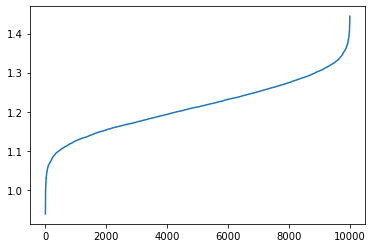

In [41]:
portfolio_daily_std_list.sort()

plt.plot(portfolio_daily_std_list)

# Next we need to calculate the porfolio return
- note that we need to fix teh code so that the weights for each associated risk is saved
    - otherewise, we wont be able to calculate the sharp ratio accurately
    - to do this we will make a dataframe containing the weights in columnsm, and teh final portfolio std value in the last column, then the return value in the next column

In [42]:
weights_risk_return_df

,ENB,RIO,GLD,DOO,F,CS,TGT,MSFT,ISRG,EMR,porfolio_std,porfolio_return
0,0.091563,0.134002,0.145252,0.053927,0.100718,0.081752,0.013916,0.118159,0.117745,0.142966,1.1983,NaN
1,0.136287,0.074879,0.092451,0.167120,0.125335,0.057359,0.075619,0.097042,0.111682,0.062226,1.1705,NaN
2,0.070137,0.019643,0.059637,0.024816,0.174313,0.097888,0.153400,0.109955,0.143835,0.146375,1.2916,NaN
3,0.074197,0.031555,0.155430,0.091462,0.134565,0.031267,0.127492,0.119451,0.139062,0.095520,1.1139,NaN
4,0.197116,0.043543,0.083761,0.068502,0.172749,0.181736,0.136787,0.036868,0.036840,0.042098,1.2834,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.130335,0.078168,0.166034,0.018188,0.159928,0.046050,0.181630,0.092432,0.102757,0.024478,1.13,NaN
9996,0.106830,0.091221,0.161426,0.117457,0.085995,0.045781,0.069612,0.093805,0.132134,0.095738,1.1052,NaN
9997,0.179683,0.035913,0.059061,0.086792,0.100820,0.056327,0.159194,0.152959,0.115866,0.053385,1.2062,NaN
9998,0.063844,0.045629,0.166206,0.046843,0.117802,0.157037,0.159643,0.043264,0.047605,0.152126,1.171,NaN


In [43]:
# to make the returns, we will make a new dictionairy representing the total returns for each stock 
# the assumption here is that we held the stock for the full duration 

full_returns_dict = {}


for ticker in ticker_list:
    full_hist = main_df[ticker].tolist()
    
    # remove any nan values from the list
    clean_hist = [x for x in full_hist if not pd.isna(x)]

    # calculate the returns from holding the stock over the full duration 
    returns_full = round(((clean_hist[-1] - clean_hist[0])/clean_hist[0])*100, 4) 
    
    # save the returns into the dict
    full_returns_dict[ticker] = returns_full 

In [44]:
full_returns_dict

{'ENB': 36.8986,
 'RIO': 135.2485,
 'GLD': 31.4598,
 'DOO': -21.5174,
 'F': 22.7609,
 'CS': -87.0485,
 'TGT': 278.9667,
 'MSFT': 691.7517,
 'ISRG': 382.0769,
 'EMR': 66.5705}

In [45]:
# next we need to calculate the porfolio returns 
# we do this by taking the sum-product of the weights and overall returns


for i in range(len(weights_risk_return_df)):
    
    # create a list to temporarily hold the partial returns 
    partial_return_list = []
    
    # lock onto one row at a time
    row = weights_risk_return_df.iloc[i:i+1, :]
    
    for col in ticker_list: # calculat the sum product of returns and weights 
        
        # multiply the weight by the corresponding return 
        partial_return = float(row[col]) * full_returns_dict[col]
        
        # append teh partial return into the list 
        partial_return_list.append(partial_return)
        
    realized_return = sum(partial_return_list)
    
    weights_risk_return_df.iloc[i:i+1, 11] = float(realized_return)

In [46]:
weights_risk_return_df

,ENB,RIO,GLD,DOO,F,CS,TGT,MSFT,ISRG,EMR,porfolio_std,porfolio_return
0,0.091563,0.134002,0.145252,0.053927,0.100718,0.081752,0.013916,0.118159,0.117745,0.142966,1.1983,160.211338
1,0.136287,0.074879,0.092451,0.167120,0.125335,0.057359,0.075619,0.097042,0.111682,0.062226,1.1705,147.366073
2,0.070137,0.019643,0.059637,0.024816,0.174313,0.097888,0.153400,0.109955,0.143835,0.146375,1.2916,185.589066
3,0.074197,0.031555,0.155430,0.091462,0.134565,0.031267,0.127492,0.119451,0.139062,0.095520,1.1139,187.956011
4,0.197116,0.043543,0.083761,0.068502,0.172749,0.181736,0.136787,0.036868,0.036840,0.042098,1.2834,82.976398
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.130335,0.078168,0.166034,0.018188,0.159928,0.046050,0.181630,0.092432,0.102757,0.024478,1.13,175.344179
9996,0.106830,0.091221,0.161426,0.117457,0.085995,0.045781,0.069612,0.093805,0.132134,0.095738,1.1052,157.970106
9997,0.179683,0.035913,0.059061,0.086792,0.100820,0.056327,0.159194,0.152959,0.115866,0.053385,1.2062,206.912371
9998,0.063844,0.045629,0.166206,0.046843,0.117802,0.157037,0.159643,0.043264,0.047605,0.152126,1.171,104.538328


## Now that we have the portfolio std and returns, we can calculate the sharp ratio

##### Sharpe ratio = (Rp - Rf) / σp

- R_p = portfolio return
- R_f = risk-free-rate
- sigma_p = portfolio standard deviation

In [47]:
# lets start by making a new column in the weights_risk_return_df dataset
R_f = 0.05 # we assume that this is an annual rate 


# find the daily compounding returns
weights_risk_return_df['sharp_ratio'] = (((1+(weights_risk_return_df['porfolio_return']/100)**(1/years))-1) - R_f)/weights_risk_return_df['porfolio_std']


## were so close!

### Nest we need to find the max value in the sharp ratio column (this will correspond the the desired portfolio wieghts)

In [48]:
index_max = int(weights_risk_return_df[['sharp_ratio']].astype('float').idxmax())

In [49]:
weights_risk_return_df.iloc[index_max:index_max+1, :]

,ENB,RIO,GLD,DOO,F,CS,TGT,MSFT,ISRG,EMR,porfolio_std,porfolio_return,sharp_ratio
1205,0.031338,0.055159,0.272045,0.119969,0.071599,0.062668,0.056628,0.20805,0.076339,0.046205,0.9916,202.727495,1.040426


In [50]:
# this is 10,000 iterations
weights_risk_return_df.iloc[index_max:index_max+1, :]

,ENB,RIO,GLD,DOO,F,CS,TGT,MSFT,ISRG,EMR,porfolio_std,porfolio_return,sharp_ratio
1205,0.031338,0.055159,0.272045,0.119969,0.071599,0.062668,0.056628,0.20805,0.076339,0.046205,0.9916,202.727495,1.040426


In [39]:
# this is 5,000 iterations
weights_risk_return_df.iloc[index_max:index_max+1, :]

,ENB,RIO,GLD,DOO,F,CS,TGT,MSFT,ISRG,EMR,porfolio_std,porfolio_return,sharp_ratio
3936,0.08918,0.054418,0.207246,0.182989,0.10589,0.02536,0.068665,0.205251,0.038872,0.022129,1.0201,190.898678,1.004299


In [28]:
# this is 500 iterations
weights_risk_return_df.iloc[index_max:index_max+1, :]

,ENB,RIO,GLD,DOO,F,CS,TGT,MSFT,ISRG,EMR,porfolio_std,porfolio_return,sharp_ratio
321,0.135882,0.020575,0.184347,0.072505,0.026785,0.055298,0.174529,0.178877,0.031297,0.119905,1.0543,200.198525,0.977121


# we can now vizialize the returns over time
- compare the equal weight porfoloi to the optimized sharp ratio

In [51]:
weights_risk_return_df.iloc[index_max:index_max+1, :]

,ENB,RIO,GLD,DOO,F,CS,TGT,MSFT,ISRG,EMR,porfolio_std,porfolio_return,sharp_ratio
1205,0.031338,0.055159,0.272045,0.119969,0.071599,0.062668,0.056628,0.20805,0.076339,0.046205,0.9916,202.727495,1.040426


In [3]:
# optimal_weights